<a href="https://colab.research.google.com/github/ibacaraujo/learning-pytorch/blob/master/what_is_torch_nn_really.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# What is torch.nn really?

PyTorch provides the elegantly designed modules and classes torch.nn, torch.optim, Dataset and DataLoader to help you create and train neural networks. In order to fully utilize their power and customize them for your problem, you need to really understand exactly what they're doing. To develop this understanding, we will first train basic neural net on the MNIST data set without using any features from these models; we will initially only use the most basic PyTorch tensor functionality. Then, we will incrementally add one feature from torch.nn, torch.optim, Dataset, or DataLoader at a time, showing exactly what each piece does, and how it works to make the code either more concise, or more flexible

## MNIST data setup

In [0]:
from pathlib import Path
import requests

DATA_PATH = Path("data")
PATH = DATA_PATH / "mnist"

PATH.mkdir(parents=True, exist_ok=True)

URL = "http://deeplearning.net/data/mnist/"
FILENAME = "mnist.pkl.gz"

if not (PATH / FILENAME).exists():
  content = requests.get(URL + FILENAME).content
  (PATH / FILENAME).open("wb").write(content)

In [0]:
import pickle
import gzip

with gzip.open((PATH / FILENAME).as_posix(), "rb") as f:
  ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, 
                                                            encoding="latin-1")

(50000, 784)


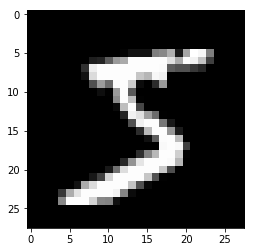

In [3]:
from matplotlib import pyplot
import numpy as np

pyplot.imshow(x_train[0].reshape((28,28)), cmap="gray")
print(x_train.shape)

PyTorch uses torch.tensor, rather than numpy arrays, so we need to convert our data.

In [4]:
import torch

x_train, y_train, x_valid, y_valid = map(torch.tensor, 
                                         (x_train, y_train, x_valid, y_valid))
n, c = x_train.shape
x_train, x_train.shape, y_train.min(), y_train.max()
print(x_train, y_train)
print(x_train.shape)
print(y_train.min(), y_train.max())

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]) tensor([5, 0, 4,  ..., 8, 4, 8])
torch.Size([50000, 784])
tensor(0) tensor(9)


## Neural net from scratch (no torch.nn)

In [0]:
import math

weights = torch.randn(784, 10) / math.sqrt(784)
weights.requires_grad_()
bias = torch.zeros(10, requires_grad=True)

You can write your own loss functions, activation functions, and so forth using plain Python. PyTorch will even create fast GPU or vectorized CPU code for your function automatically.

In [0]:
# activation function
def log_softmax(x):
  return x - x.exp().sum(-1).log().unsqueeze(-1)

# simple linear model
def model(xb):
  return log_softmax(xb @ weights + bias)

We will call our function on one batch of data. This is one forward pass.

In [7]:
bs = 64 # batch size

xb = x_train[0:bs] # a mini-batch from x
preds = model(xb)
preds[0], preds.shape
print(preds[0])
print(preds.shape)

tensor([-1.9530, -2.3301, -2.0890, -2.2190, -2.2934, -2.6652, -2.7075, -2.3250,
        -2.4774, -2.2130], grad_fn=<SelectBackward>)
torch.Size([64, 10])


The preds tensor also contain a gradient function that we can use for backprop.

Let's implement now negative log-likelihood to use as the loss function using standard Python.

In [0]:
def nll(preds, targets):
  print(preds.shape)
  print(range(targets.shape[0]))
  print(targets)
  return -preds[range(targets.shape[0]), targets].mean()

In [9]:
yb = y_train[0:bs]
print(nll(preds, yb))

torch.Size([64, 10])
range(0, 64)
tensor([5, 0, 4, 1, 9, 2, 1, 3, 1, 4, 3, 5, 3, 6, 1, 7, 2, 8, 6, 9, 4, 0, 9, 1,
        1, 2, 4, 3, 2, 7, 3, 8, 6, 9, 0, 5, 6, 0, 7, 6, 1, 8, 7, 9, 3, 9, 8, 5,
        9, 3, 3, 0, 7, 4, 9, 8, 0, 9, 4, 1, 4, 4, 6, 0])
tensor(2.3465, grad_fn=<NegBackward>)


Let's also implement a function to calculate the accuracy of our model. For a prediction, for each one, if the index with the largest value matches the target value, then the prediction was correct.

In [0]:
def accuracy(preds, targets):
  preds = torch.argmax(preds, dim=1)
  print((preds == targets))
  return (preds == targets).float().mean()

In [11]:
print(accuracy(preds, yb))

tensor([False, False, False,  True, False, False, False, False, False, False,
        False, False,  True, False, False, False, False, False, False, False,
        False, False, False,  True, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
         True, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,  True,
        False, False, False, False])
tensor(0.0781)


Now, let's run the training loop. For each iteration, we will:



1.   select a mini-batch of data (of size bs)
2.   use the model to make predictions
3.   calculate the loss
4.   call loss.backward() to use the gradients to update the parameters of the model, in this case, weights and bias.

**TIP**. We can use the standard Python debugger to step through PyTorch code, allowing us to check the various variable values at each step.



In [12]:
from IPython.core.debugger import set_trace

lr = 0.5 # learning rate
epochs = 2 # how many epochs to train for

for epoch in range(epochs):
  for i in range((n - 1) // bs + 1):
    # set_trace()
    start_i = i * bs
    end_i = start_i + bs
    xb = x_train[start_i:end_i]
    yb = y_train[start_i:end_i]
    pred = model(xb)
    loss = nll(pred, yb)
    loss.backward()

    with torch.no_grad(): # update parameters in no_grad context
      weights -= weights.grad * lr
      bias -= bias.grad * lr
      weights.grad.zero_()
      bias.grad.zero_()

torch.Size([64, 10])
range(0, 64)
tensor([5, 0, 4, 1, 9, 2, 1, 3, 1, 4, 3, 5, 3, 6, 1, 7, 2, 8, 6, 9, 4, 0, 9, 1,
        1, 2, 4, 3, 2, 7, 3, 8, 6, 9, 0, 5, 6, 0, 7, 6, 1, 8, 7, 9, 3, 9, 8, 5,
        9, 3, 3, 0, 7, 4, 9, 8, 0, 9, 4, 1, 4, 4, 6, 0])
torch.Size([64, 10])
range(0, 64)
tensor([4, 5, 6, 1, 0, 0, 1, 7, 1, 6, 3, 0, 2, 1, 1, 7, 9, 0, 2, 6, 7, 8, 3, 9,
        0, 4, 6, 7, 4, 6, 8, 0, 7, 8, 3, 1, 5, 7, 1, 7, 1, 1, 6, 3, 0, 2, 9, 3,
        1, 1, 0, 4, 9, 2, 0, 0, 2, 0, 2, 7, 1, 8, 6, 4])
torch.Size([64, 10])
range(0, 64)
tensor([1, 6, 3, 4, 5, 9, 1, 3, 3, 8, 5, 4, 7, 7, 4, 2, 8, 5, 8, 6, 7, 3, 4, 6,
        1, 9, 9, 6, 0, 3, 7, 2, 8, 2, 9, 4, 4, 6, 4, 9, 7, 0, 9, 2, 9, 5, 1, 5,
        9, 1, 2, 3, 2, 3, 5, 9, 1, 7, 6, 2, 8, 2, 2, 5])
torch.Size([64, 10])
range(0, 64)
tensor([0, 7, 4, 9, 7, 8, 3, 2, 1, 1, 8, 3, 6, 1, 0, 3, 1, 0, 0, 1, 7, 2, 7, 3,
        0, 4, 6, 5, 2, 6, 4, 7, 1, 8, 9, 9, 3, 0, 7, 1, 0, 2, 0, 3, 5, 4, 6, 5,
        8, 6, 3, 7, 5, 8, 0, 9, 1, 0, 3, 1, 2, 2, 3, 

That's it. We created and trained a minimal neural network entirely from scratch. In this case, a logistic regression since we have no hidden layers.

Let's check the loss and accuracy and compare those to what we got earlier. We expect that the loss will have decreased and the accuracy will have increased.

In [13]:
print('explicit output: ', nll(model(xb), yb), accuracy(model(xb), yb))

torch.Size([16, 10])
range(0, 16)
tensor([9, 3, 7, 0, 9, 0, 8, 5, 5, 2, 4, 5, 0, 8, 4, 8])
tensor([True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True])
explicit output:  tensor(0.0823, grad_fn=<NegBackward>) tensor(1.)


## Using torch.nn.functional

To make the code shorter replacing the loss function and activation function with those from torch.nn.functional, convetional imported into the namespace F. This module contains all the functions from the torch.nn library.

As we are using negative log-likelihood as the loss function and the log softmax as the activation function, we can replace them using a single function provided by PyTorch, F.cross_entropy. This function combines the two.

In [0]:
import torch.nn.functional as F

loss_func = F.cross_entropy

def model(xb):
  return xb @ weights + bias

Note that we no longer call log softmax in the model function because the loss function includes it.

Let's confirm that our loss function and accuracy are the same as before.

In [15]:
print('loss: ', loss_func(model(xb), yb))
print('accuracy: ', accuracy(model(xb), yb))

loss:  tensor(0.0823, grad_fn=<NllLossBackward>)
tensor([True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True])
accuracy:  tensor(1.)


## Refactor using torch.nn.Module

Let's make the training loop clearer and more concise. We will create a class that represents our model. It will hold the weights, the bias and the method for the forward step.

In [0]:
from torch import nn

class Mnist_Logistic_Regression(nn.Module):
  def __init__(self):
    super().__init__()
    self.weights = nn.Parameter(torch.randn(784,10) / math.sqrt(784))
    self.bias = nn.Parameter(torch.zeros(10))

  def forward(self, xb):
    return xb @ self.weights + self.bias

In [0]:
model = Mnist_Logistic_Regression()

We can calculate the loss now using the model. Pay attention that we call nn.Module objects as if they are functions (i.e. they are callable), but behing the scenes PyTorch will call our forward method automatically.

In [18]:
print(loss_func(model(xb), yb))

tensor(2.2941, grad_fn=<NllLossBackward>)


Let's take advantage now of model.parameters() and model.zero_grad() to make the training loop more concise.

We are wrapping the training loop in a fit function.

In [0]:
def fit():loss.backward()
  for epoch in range(epochs):
    for i in range((n-1) // bs + 1):
      start_i = i * bs
      end_i = start_i + bs
      xb = x_train[start_i:end_i]
      yb = y_train[start_i:end_i]
      pred = model(xb)
      loss = loss_func(pred, yb)
      loss.backward()

      with torch.no_grad():
        for p in model.parameters():
          p -= p.grad * lr
        model.zero_grad()

In [0]:
fit()

In [21]:
print(loss_func(model(xb), yb))

tensor(0.0799, grad_fn=<NllLossBackward>)


Great! It works double checking that our loss decreased!

## Refactor using nn.Linear

Let's use the class nn.Linear to create the neuron instead of defining the self.weights and self.bias and the operation xb @ self.weights + self.bias.

In [0]:
class Mnist_Logistic_Regression(nn.Module):
  def __init__(self):
    super().__init__()
    self.lin = nn.Linear(784, 10)

  def forward(self, xb):
    return self.lin(xb)

In [23]:
model = Mnist_Logistic_Regression()
print(loss_func(model(xb), yb))

tensor(2.2707, grad_fn=<NllLossBackward>)


In [24]:
fit()
print(loss_func(model(xb), yb))

tensor(0.0805, grad_fn=<NllLossBackward>)


## Refactor using optim

In [0]:
from torch import optim

In [0]:
# function to define our model and optimizer for reuse
def get_model():
  model = Mnist_Logistic_Regression()
  return model, optim.SGD(model.parameters(), lr=lr)

In [28]:
model, opt = get_model()
print(loss_func(model(xb), yb))

tensor(2.3716, grad_fn=<NllLossBackward>)


In [29]:
# training loop
for epoch in range(epochs):
  for i in range((n-1) // bs + 1):
    start_i = i * bs
    end_i = start_i + bs
    xb = x_train[start_i:end_i]
    yb = y_train[start_i:end_i]
    y_pred = model(xb)
    loss = loss_func(y_pred, yb)
    loss.backward()
    opt.step()
    opt.zero_grad()

print(loss_func(model(xb), yb))

tensor(0.0809, grad_fn=<NllLossBackward>)


## Refactor using Datasets

In [0]:
from torch.utils.data import TensorDataset

In [0]:
# x_train and y_train can be combined into a TensorDataset instance
# it makes easier to iterate over and slice
train_ds = TensorDataset(x_train, y_train)

In [33]:
model, opt = get_model()
print(loss_func(model(xb), yb))

# training loop
for epoch in range(epochs):
  for i in range((n-1) // bs + 1):
    xb, yb = train_ds[i*bs:i*bs+bs]
    y_pred = model(xb)
    loss = loss_func(y_pred, yb)
    loss.backward()
    opt.step()
    opt.zero_grad()

print(loss_func(model(xb), yb))

tensor(2.3207, grad_fn=<NllLossBackward>)
tensor(0.0827, grad_fn=<NllLossBackward>)


## Refactor using DataLoader

DataLoader is responsible for managing batches. You can create a DataLoader from a Dataset.

In [0]:
from torch.utils.data import DataLoader

In [0]:
# It makes easier to iterate over batches.
train_dl = DataLoader(train_ds, batch_size=bs)

In [38]:
model, opt = get_model()
print(loss_func(model(xb), yb))

# training loop
for epoch in range(epochs):
  for xb, yb in train_dl:
    y_pred = model(xb)
    loss = loss_func(y_pred, yb)
    loss.backward()
    opt.step()
    opt.zero_grad()

print(loss_func(model(xb), yb))

tensor(2.2552, grad_fn=<NllLossBackward>)
tensor(0.0824, grad_fn=<NllLossBackward>)


## Add validation

In [0]:
train_ds = TensorDataset(x_train, y_train)
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True)

valid_ds = TensorDataset(x_valid, y_valid)
valid_dl = DataLoader(valid_ds, batch_size=bs*2)

In [42]:
model, opt = get_model()

for epoch in range(epochs):
  model.train()
  for xb, yb in train_dl:
    y_pred = model(xb)
    loss = loss_func(y_pred, yb)
    loss.backward()
    opt.step()
    opt.zero_grad()

  model.eval()
  with torch.no_grad():
    valid_loss = sum(loss_func(model(xb), yb) for xb, yb in valid_dl)
  
  print(epoch, valid_loss / len(valid_dl))

0 tensor(0.3476)
1 tensor(0.3126)


## Create fit() and get_data()

In [0]:
def loss_batch(model, loss_func, xb, yb, opt=None):
  loss = loss_func(model(xb), yb)

  if opt is not None:
    loss.backward()
    opt.step()
    opt.zero_grad()

  return loss.item(), len(xb)

In [0]:
import numpy as np

# fit runs the necessary operations to train our model 
# and compute the training and validation losses for each epoch.
def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
  for epoch in range(epochs):
    model.train()
    for xb, yb in train_dl:
      loss_batch(model, loss_func, xb, yb, opt)

    model.eval()
    with torch.no_grad():
      losses, lens_bs = zip(
          *[loss_batch(model, loss_func, xb, yb) 
                           for xb, yb in valid_dl])
      val_loss = np.sum(np.multiply(losses, lens_bs)) / np.sum(lens_bs)
      print(epoch, val_loss)


In [0]:
# get_data returns dataloaders for the training and validation sets
def get_data(train_ds, valid_ds, bs):
  return (
    DataLoader(train_ds, batch_size=bs, shuffle=True),
    DataLoader(valid_ds, batch_size=bs*2)
  )

In [50]:
# whole process now
# 3 lines of code
train_dl, valid_dl = get_data(train_ds, valid_ds, bs)
model, opt = get_model()
fit(epochs, model, loss_func, opt, train_dl, valid_dl)

0 0.3137512716650963
1 0.30077165467739103


## Switch to CNN

Because none of the functions assume a model format, we will use all of them to train our CNN model.

In [0]:
class Mnist_CNN(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1)
    self.conv2 = nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1)
    self.conv3 = nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1)

  def forward(self, xb):
    xb = xb.view(-1, 1, 28, 28)
    xb = F.relu(self.conv1(xb))
    xb = F.relu(self.conv2(xb))
    xb = F.relu(self.conv3(xb))
    xb = F.avg_pool2d(xb, kernel_size=4)
    return xb.view(-1, xb.size(1))

In [0]:
lr = 0.1

In [0]:
model = Mnist_CNN()
opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

In [55]:
fit(epochs, model, loss_func, opt, train_dl, valid_dl)

0 0.31454824334383014
1 0.2850929828763008


## nn.Sequential

In [0]:
# Lambda will create a layer that we can then use 
# when defining a network with Sequential.
class Lambda(nn.Module):
  def __init__(self, func):
    super().__init__()
    self.func = func

  def forward(self, x):
    return self.func(x)

def preprocess(x):
  return x.view(-1, 1, 28, 28)

In [0]:
model = nn.Sequential(
    Lambda(preprocess),
    nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.AvgPool2d(4),
    Lambda(lambda x: x.view(x.size(0), -1))
)

In [0]:
opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

In [60]:
fit(epochs, model, loss_func, opt, train_dl, valid_dl)

0 0.3219357112169266
1 0.21912095468044282


## Wrapping DataLoader

In [0]:
def preprocess(x, y):
  return x.view(-1, 1, 28, 28), y

class WrappedDataLoader:
  def __init__(self, dl, func):
    self.dl = dl
    self.func = func

  def __len__(self):
    return len(self.dl)

  def __iter__(self):
    batches = iter(self.dl)
    for b in batches:
      yield (self.func(*b))

In [0]:
train_dl, valid_dl = get_data(train_ds, valid_ds, bs)
train_dl = WrappedDataLoader(train_dl, preprocess)
valid_dl = WrappedDataLoader(valid_dl, preprocess)

In [0]:
model = nn.Sequential(
    nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.AdaptiveAvgPool2d(1),
    Lambda(lambda x: x.view(x.size(0), -1))
)

In [0]:
opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

In [65]:
fit(epochs, model, loss_func, opt, train_dl, valid_dl)

0 0.37673516145944597
1 0.35438381166458127


## Using your GPU

In [66]:
# check if it is working in PyTorch
print(torch.cuda.is_available())

True


In [0]:
# create a device object for it
dev = torch.device("cuda") if torch.cuda.is_available() else torch.device('cpu')

In [0]:
# update preprocess to move batches to the GPU
def preprocess(x, y):
  return x.view(-1, 1, 28, 28).to(dev), y.to(dev)

In [0]:
train_dl, valid_dl = get_data(train_ds, valid_ds, bs)
train_dl = WrappedDataLoader(train_dl, preprocess)
valid_dl = WrappedDataLoader(valid_dl, preprocess)

In [70]:
# finally, we can move our model to the GPU
model.to(dev)

Sequential(
  (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (1): ReLU()
  (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (3): ReLU()
  (4): Conv2d(16, 10, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (5): ReLU()
  (6): AdaptiveAvgPool2d(output_size=1)
  (7): Lambda()
)

In [0]:
opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

In [72]:
# you should find it runs faster now
fit(epochs, model, loss_func, opt, train_dl, valid_dl)

0 0.22056887173652648
1 0.20867791814804076


## Closing thoughts

We now have a general data pipeline and training loop which you can use for training many types of models using PyTorch.